In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import itertools
import statsmodels.api as sm
import networkx as nx
import seaborn as sns
import pandas as pd

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset
from spikeometric.stimulus import RegularStimulus

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx
from CD_methods import SCM_learner

from tqdm import tqdm

In [2]:
example_network = torch.load('data/c_elegans_data.pt')

In [3]:
# model parameters
theta = 3

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=theta,
    dt=1.,
    coupling_window=1,
    abs_ref_scale=3,
    abs_ref_strength=-100,
    rel_ref_scale=0,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

In [4]:
n_neurons = example_network.num_nodes
n_obs = 88
pos_thr = 0.15
n_hidden = n_neurons - n_obs

G = to_networkx(example_network, node_attrs = ['position'])
position_dict = nx.get_node_attributes(G, 'position')
sample_space = []
for neuron in position_dict:
    if position_dict[neuron] < pos_thr:
        sample_space.append(neuron)

print('num possible samples = ',len(sample_space))        
index_obs = np.sort(np.random.choice(sample_space, size = n_obs, replace = False))
#index_obs = np.sort(sample_space)
#print(sample_space)
print('n_obs = ', n_obs)
print('n_edges = ', example_network.num_edges)
print('n_neurons = ', example_network.num_nodes)

G_obs = nx.subgraph(G, index_obs)

index_hidden = [node for node in range(n_neurons) if node not in index_obs]
confounders = []
for node in index_hidden:
    count = 0
    for _, v in G.out_edges(node):
        if v in index_obs:
            count += 1
    if count >= 2:
        confounders.append(node)
print('num. confounding variables = ',len(confounders))

num possible samples =  88
n_obs =  88
n_edges =  2194
n_neurons =  279
num. confounding variables =  86


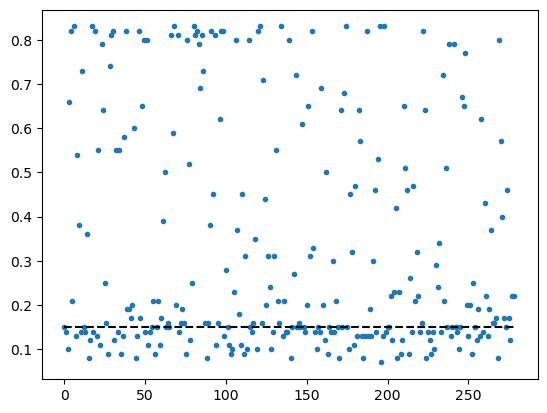

In [5]:
plt.scatter(np.arange(n_neurons), position_dict.values(), marker='.')
plt.hlines(y=pos_thr, xmin=0, xmax=n_neurons, linestyles='dashed', colors='black')

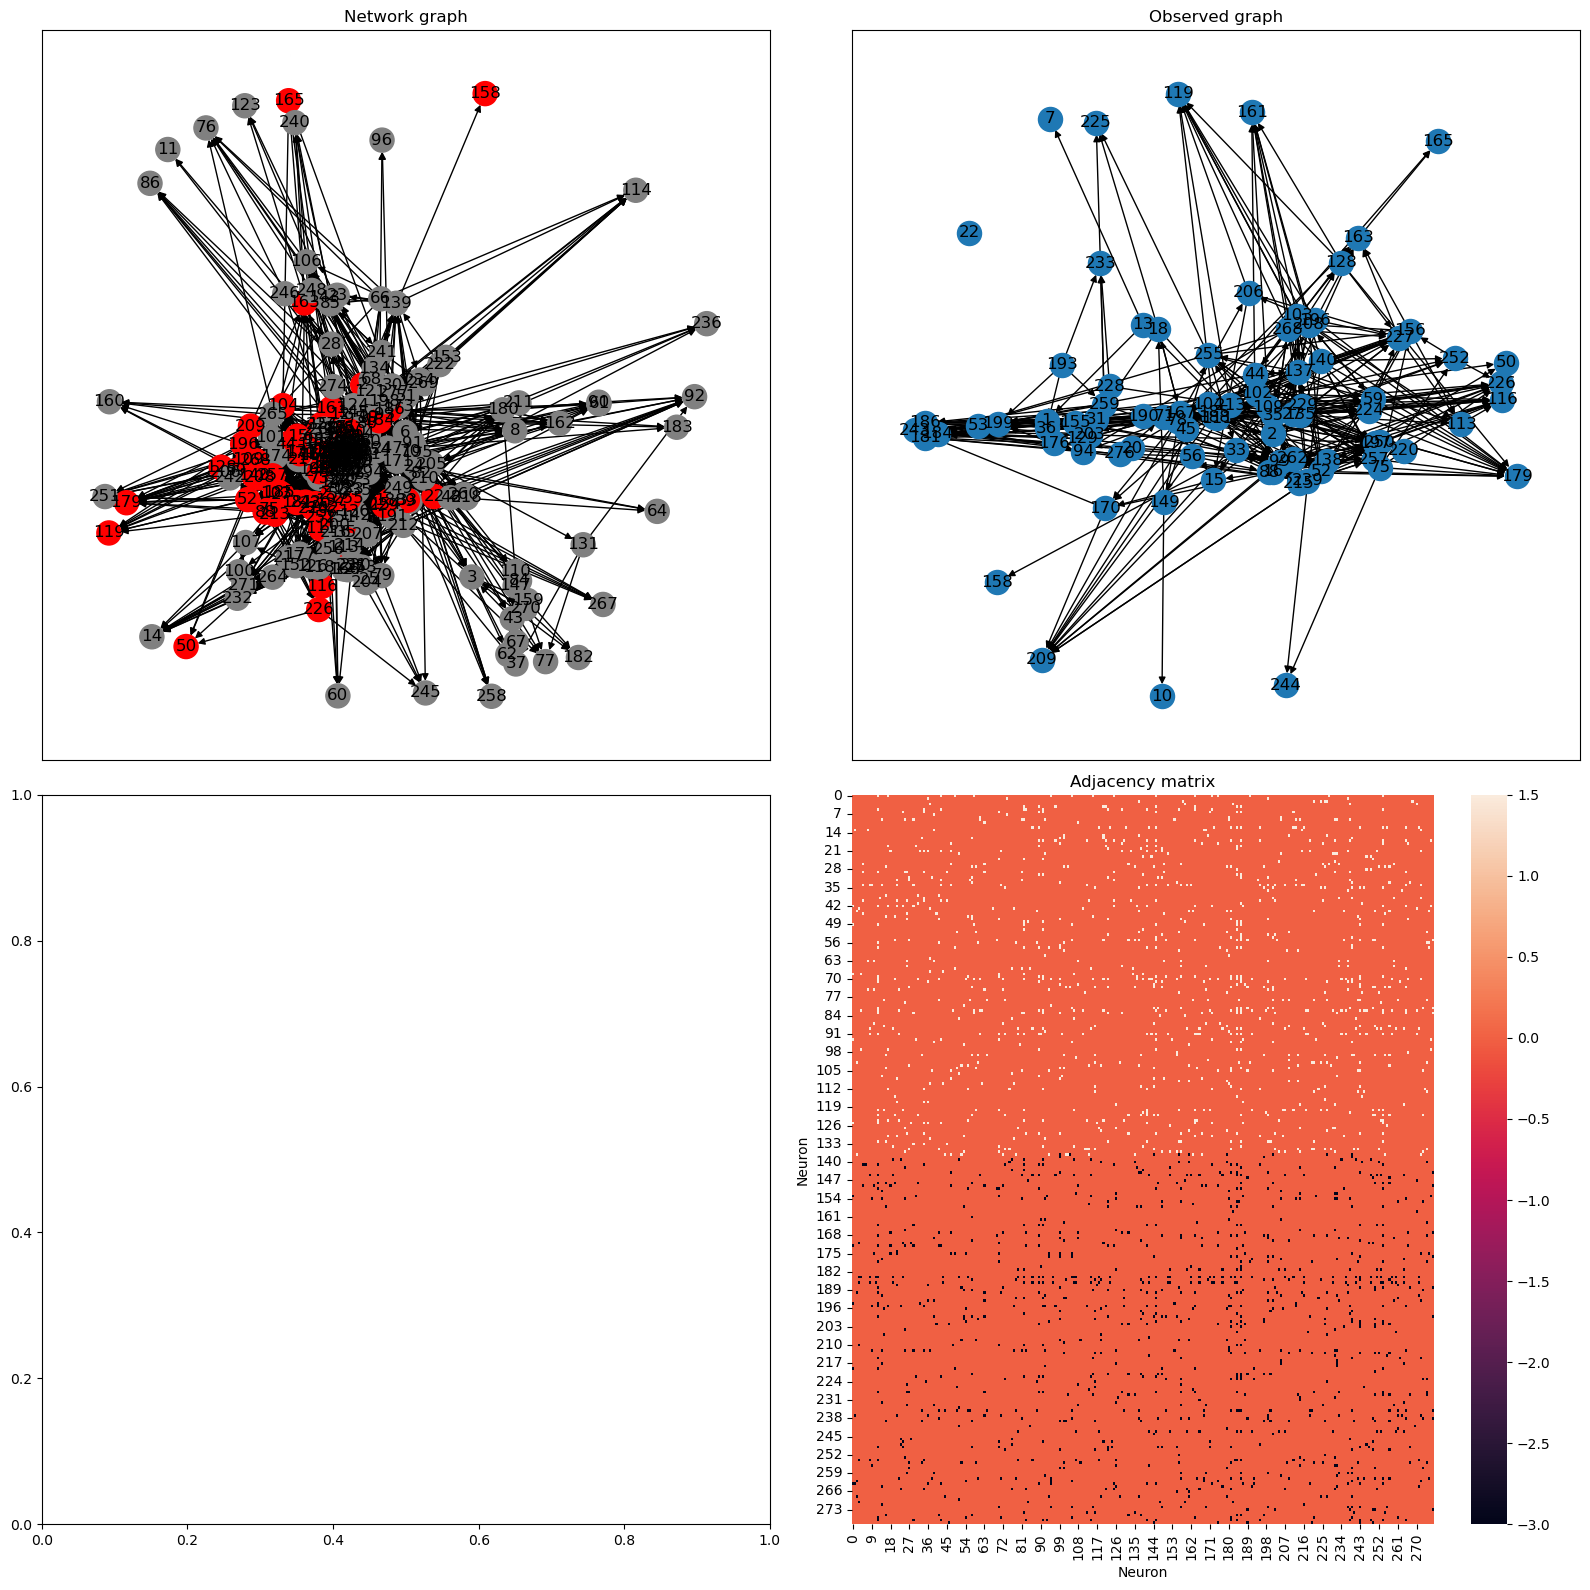

In [6]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
color_map = ['grey' if node not in index_obs else 'red' for node in G]        

nx.draw_networkx(G, arrows=True, ax=ax[0,0], node_color=color_map)
ax[0,0].set_title("Network graph")

nx.draw_networkx(G_obs, arrows=True, ax=ax[0,1])
ax[0,1].set_title("Observed graph")

W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
sns.heatmap(W0, ax=ax[1,1], annot=False)
ax[1,1].set_title("Adjacency matrix")
ax[1,1].set_xlabel("Neuron")
ax[1,1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

In [7]:
prop_intervened = 1.0

spike_data = []
spike_data_dict = dict()
n_timesteps = 10**4

# complete single neuron stimulation protocol
stimulation_protocol = [[i] for i in index_obs]
stimulation_protocol_str = [str(i) for i in index_obs] + ['null']

stimulate_nodes = np.sort(np.random.choice(index_obs, size = int(n_obs*prop_intervened), replace = False))
stimulation_protocol = [[i] for i in stimulate_nodes]
stimulation_protocol_str = [str(i) for i in stimulate_nodes] + ['null']

In [8]:
for i, intervention in tqdm(enumerate(stimulation_protocol_str), total = len(stimulation_protocol_str)):
    stimulus_mask = torch.zeros(n_neurons, dtype=torch.bool)
    
    if intervention != 'null':
        intervention_set = stimulation_protocol[i]
        stimulus_mask[intervention_set] = True
        
    neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
    spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)
    
    spike_data_dict[intervention] = spikes[index_obs]

100%|███████████████████████████████████████████| 89/89 [01:22<00:00,  1.08it/s]


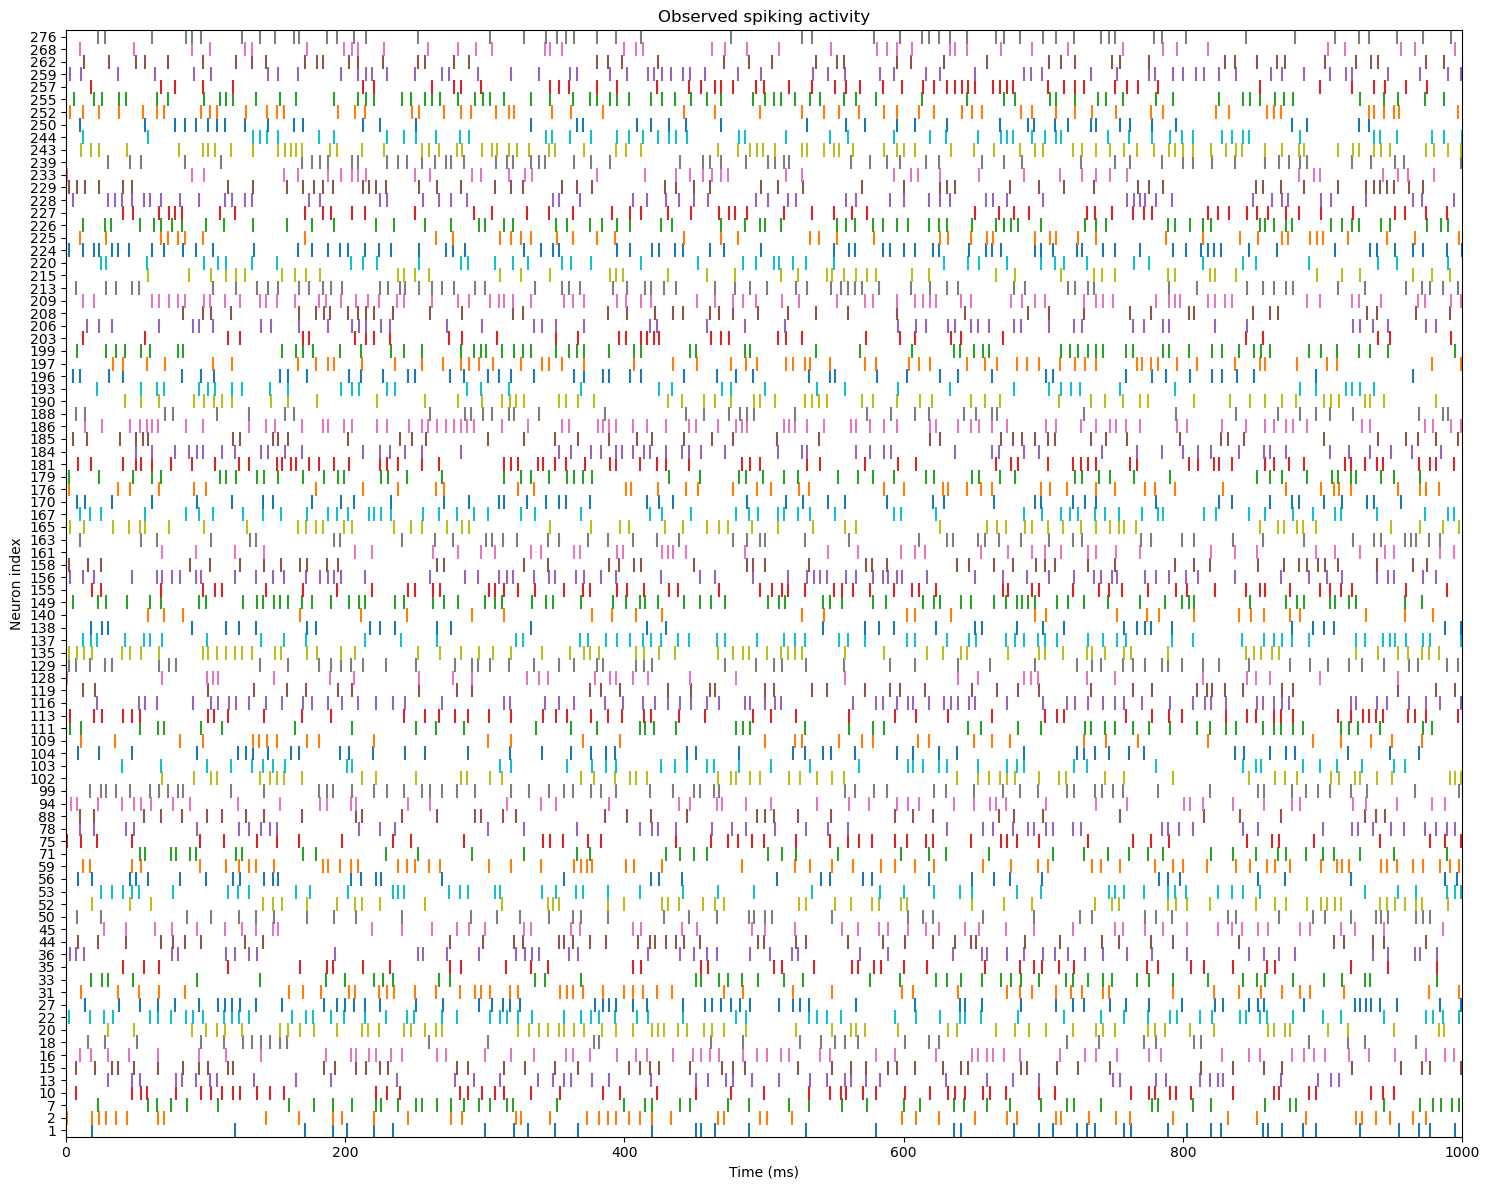

In [9]:
spikes = spike_data_dict['null']

plt.figure(figsize=(15,12))

for i in range(len(index_obs)):
    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)

plt.yticks(ticks=np.arange(len(index_obs)),labels=index_obs)
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0, 1000])
plt.ylim([-0.5, n_obs - 0.5])
plt.title("Observed spiking activity")
plt.tight_layout()
plt.show()

In [11]:
G_learned = SCM_learner(spike_data_dict, 
                        node_list=list(index_obs), 
                        stimulation_protocol=stimulation_protocol, 
                        alpha = 0.01)

100%|███████████████████████████████████████████| 88/88 [00:03<00:00, 27.83it/s]


In [12]:
G_true = nx.subgraph(G, index_obs)

A_true = nx.adjacency_matrix(G_true).todense() 
A_learned = nx.adjacency_matrix(G_learned).todense() 
A_diff = A_true - A_learned

pd.DataFrame(A_true - A_learned)
SHD = np.sum(np.abs(A_true- A_learned))
TP = np.sum( (A_true == 1)*(A_learned==1) )
TN = np.sum( (A_true == 0)*(A_learned==0)) 
FP = np.sum(A_diff == -1)
FN = np.sum(A_diff == 1) 

index_hidden = [node for node in range(n_neurons) if node not in index_obs]
confounders = []
for node in index_hidden:
    count = 0
    for _, v in G.out_edges(node):
        if v in index_obs:
            count += 1
    if count >= 2:
        confounders.append(node)
print('num. confounding variables = ',len(confounders))

print('total edges (in true observed graph) = ',G_true.number_of_edges())
print('percentage of nodes observed = ', np.round(G_obs.number_of_nodes() / G.number_of_nodes() * 100, 2), '%')
print('SHD = ', SHD)
print('True positives = ', TP, ', Sensitivity = ', np.round(TP / (TP + FP) * 100, 2) )
print('True negatives = ', TN, ', Specificity = ', np.round(TN / (TN + FN)*100, 2) )
print('False positives = ', FP )
print('False negatives = ', FN )

num. confounding variables =  86
total edges (in true observed graph) =  381
percentage of nodes observed =  31.54 %
SHD =  1
True positives =  381 , Sensitivity =  99.74
True negatives =  7362 , Specificity =  100.0
False positives =  1
False negatives =  0


- plot antall FP eller FN på y-aksen som funksjon av antall celler observert
- ROC kurve 
- se på hvor mye reel konfounding det er i dataene du jobber med (hvis alle nevroner i hodet er observert forsvinner confounding effekter raskt)
    - kan man kvantifisere hvor mye confounding det er i systemet?
    - Fx ved å telle antall ikke-observerte noder som er foreldre til to eller flere av de observerte nodene
